In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [30]:
data = pd.read_csv('../data/S&P 500 Materials 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),S&P 500 Materials (Sector) Outperform/Underperform,overall,transportation,energy,energy commodities,fuels and utilities,transportation services
0,1993-05-04,444.05,90.040001,-1.150884,-0.177379,-0.1773791633274624,144.300,129.900,103.900,96.400,121.400,162.600
1,1993-05-05,444.52,89.930000,-0.275939,-0.066672,OUTPERFORM,144.300,129.900,103.900,96.400,121.400,162.600
2,1993-05-06,443.26,89.500000,-0.621034,-0.300765,OUTPERFORM,144.300,129.900,103.900,96.400,121.400,162.600
3,1993-05-07,442.31,89.239998,-1.117793,-0.446230,OUTPERFORM,144.300,129.900,103.900,96.400,121.400,162.600
4,1993-05-10,442.80,88.970001,-0.979471,-0.968383,OUTPERFORM,144.300,129.900,103.900,96.400,121.400,162.600
...,...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,551.250000,4.852728,6.056521,OUTPERFORM,280.126,250.105,263.553,309.682,272.154,326.397
7195,2021-11-26,4594.62,541.520020,1.616263,2.576155,OUTPERFORM,280.126,250.105,263.553,309.682,272.154,326.397
7196,2021-11-29,4655.27,544.190002,1.484354,0.932938,UNDERPERFORM,280.126,250.105,263.553,309.682,272.154,326.397
7197,2021-11-30,4567.00,530.679993,1.396956,-1.012850,UNDERPERFORM,280.126,250.105,263.553,309.682,272.154,326.397


## Using data after 2010  (Best Model)

In [31]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),S&P 500 Materials (Sector) Outperform/Underperform,overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
200,2010,1,2010-01-14,1148.46,206.130005,-2.110431,0.428748,OUTPERFORM,217.281,191.978,209.624,239.914,212.638,257.050,3
201,2010,2,2010-02-11,1078.47,187.250000,-11.020997,-11.611992,UNDERPERFORM,217.353,191.375,209.326,237.315,214.506,257.804,3
202,2010,3,2010-03-11,1150.24,199.759995,5.750719,8.920393,OUTPERFORM,217.403,191.249,209.219,237.093,214.821,258.306,3
203,2010,4,2010-04-08,1186.44,210.339996,6.168177,11.698794,OUTPERFORM,217.290,190.231,206.631,232.440,214.303,258.969,3
204,2010,5,2010-05-13,1157.44,195.979996,3.805347,0.579928,UNDERPERFORM,217.199,189.426,203.764,227.477,213.427,259.454,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,511.019989,-2.530346,0.450136,OUTPERFORM,273.092,236.783,242.958,276.734,262.483,326.470,3
339,2021,8,2021-08-12,4460.83,541.940002,-1.849766,1.732646,OUTPERFORM,274.214,237.107,245.847,280.047,265.333,323.329,3
340,2021,9,2021-09-09,4493.28,525.940002,-4.490556,-5.224081,UNDERPERFORM,276.590,241.826,255.010,293.342,270.870,323.995,3
341,2021,10,2021-10-14,4438.26,526.789978,-7.366228,-6.514645,OUTPERFORM,278.524,246.749,261.257,305.653,271.467,326.256,3


In [33]:
original = data[['S&P 500 Materials (Sector) Outperform/Underperform','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]

In [34]:
data.drop(columns=['date','S&P 500 Materials (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
200,1,1148.46,206.130005,-2.110431,0.428748,217.281,191.978,209.624,239.914,212.638,257.050,3
201,2,1078.47,187.250000,-11.020997,-11.611992,217.353,191.375,209.326,237.315,214.506,257.804,3
202,3,1150.24,199.759995,5.750719,8.920393,217.403,191.249,209.219,237.093,214.821,258.306,3
203,4,1186.44,210.339996,6.168177,11.698794,217.290,190.231,206.631,232.440,214.303,258.969,3
204,5,1157.44,195.979996,3.805347,0.579928,217.199,189.426,203.764,227.477,213.427,259.454,3


In [35]:
original['Performance'] = np.where(original['S&P 500 Materials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]

In [36]:
dd.data_summary(original)

,Info
Rows,143
Columns,8
Size in Memory,10.1 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.61,0.49,2,87
month,int64,0,0,1,6,12,6.46,3.43,12,12
overall,float64,0,0,217.20,238.033,280.13,241.91,14.66,141,2
transportation,float64,0,0,188.78,209.96,250.10,208.81,11.62,143,1
energy,float64,0,0,176.40,218.54,263.55,221.44,21.49,143,1
energy commodities,float64,0,0,164.91,244.44,336.42,253.77,45.069,143,1
fuels and utilities,float64,0,0,212.64,233.35,272.15,233.33,12.69,143,1
transportation services,float64,0,0,257.050,295.59,333.37,296.10,22.11,143,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

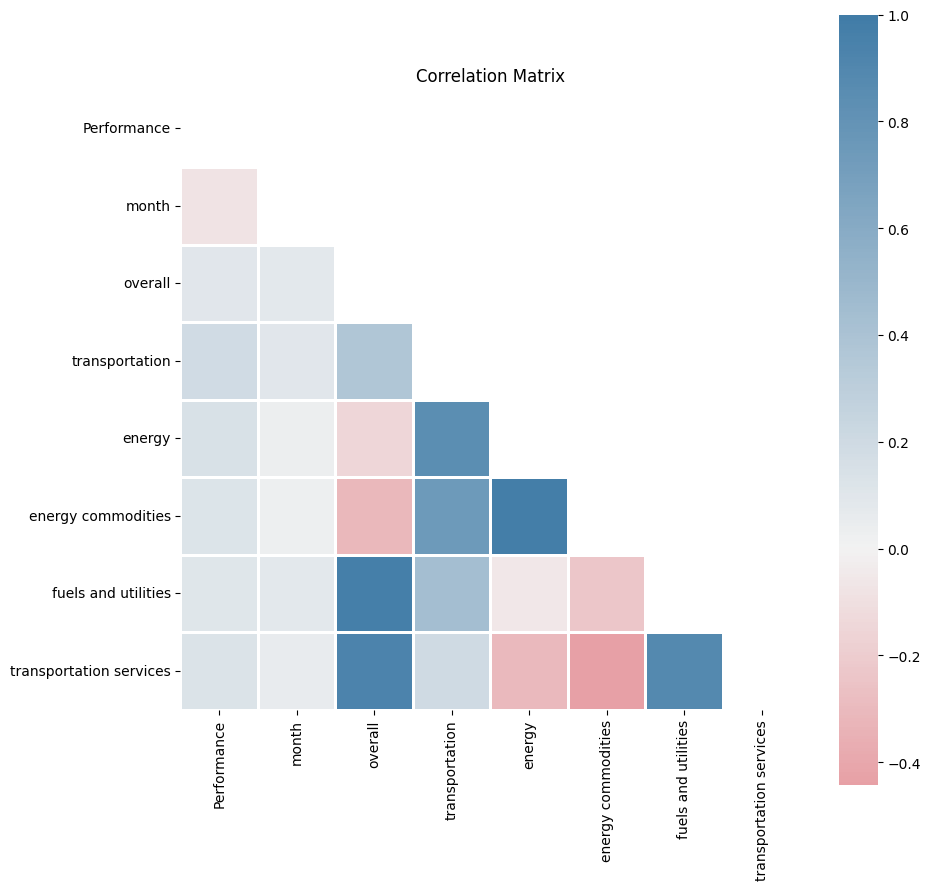

In [37]:
dd.correlation_matrix(original)

### Conditional GAN

In [38]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
0,11,2762.030758,326.421961,-3.013419,-0.920418,242.648183,201.058026,199.103587,210.236790,218.955121,311.530199,3
1,12,4905.762770,617.043937,-5.867829,-5.087838,279.456642,249.075283,241.361197,234.162824,259.403473,319.803396,3
2,11,2485.576048,348.038161,-5.532656,-5.905890,252.815280,215.661320,239.775097,297.118612,255.788956,325.690045,3
3,12,1740.734000,252.922445,-0.025095,5.304818,237.362602,192.293585,198.197036,213.505822,224.951449,277.701859,3
4,1,2125.029056,238.133533,-5.018650,-3.266986,239.474178,196.044567,203.422308,213.549665,235.616514,265.859264,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8,1707.781944,241.501026,4.036350,-2.677663,219.775733,196.132672,201.985830,224.038888,220.497471,285.939439,3
9996,10,2867.544997,369.903775,2.239608,0.544775,268.076424,212.021284,226.940606,240.220151,242.240853,327.177975,3
9997,9,2247.965107,342.145913,-2.255044,0.358700,234.894794,209.751420,207.969678,223.271195,239.794276,314.132457,3
9998,4,1697.526723,227.582434,-3.665539,-1.520201,218.798672,189.602464,197.169645,203.575015,217.944046,270.351268,3


In [39]:
samples['Performance'] = np.where(samples['S&P 500 Materials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [40]:
samples = samples[['Performance','month', 'overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
samples.head()

,Performance,month,overall,transportation,energy,energy commodities,fuels and utilities,transportation services
0,1,11,242.648183,201.058026,199.103587,210.236790,218.955121,311.530199
1,1,12,279.456642,249.075283,241.361197,234.162824,259.403473,319.803396
2,0,11,252.815280,215.661320,239.775097,297.118612,255.788956,325.690045
3,1,12,237.362602,192.293585,198.197036,213.505822,224.951449,277.701859
4,1,1,239.474178,196.044567,203.422308,213.549665,235.616514,265.859264


In [41]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,8
Size in Memory,625.1 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.65,0.48,2,6535
month,int64,0,0,1,6,12,6.46,3.45,12,876
overall,float64,0,0,206.44,242.27,291.71,244.46,15.70,10000,1
transportation,float64,0,0,184.56,209.40,274.062,208.48,14.34,9999,2
energy,float64,0,0,172.61,212.23,259.044,218.27,21.64,10000,1
energy commodities,float64,0,0,158.54,225.78,334.47,244.75,46.32,10000,1
fuels and utilities,float64,0,0,203.30,236.23,283.40,233.57,14.81,9999,2
transportation services,float64,0,0,231.92,293.33,342.044,295.59,23.055,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

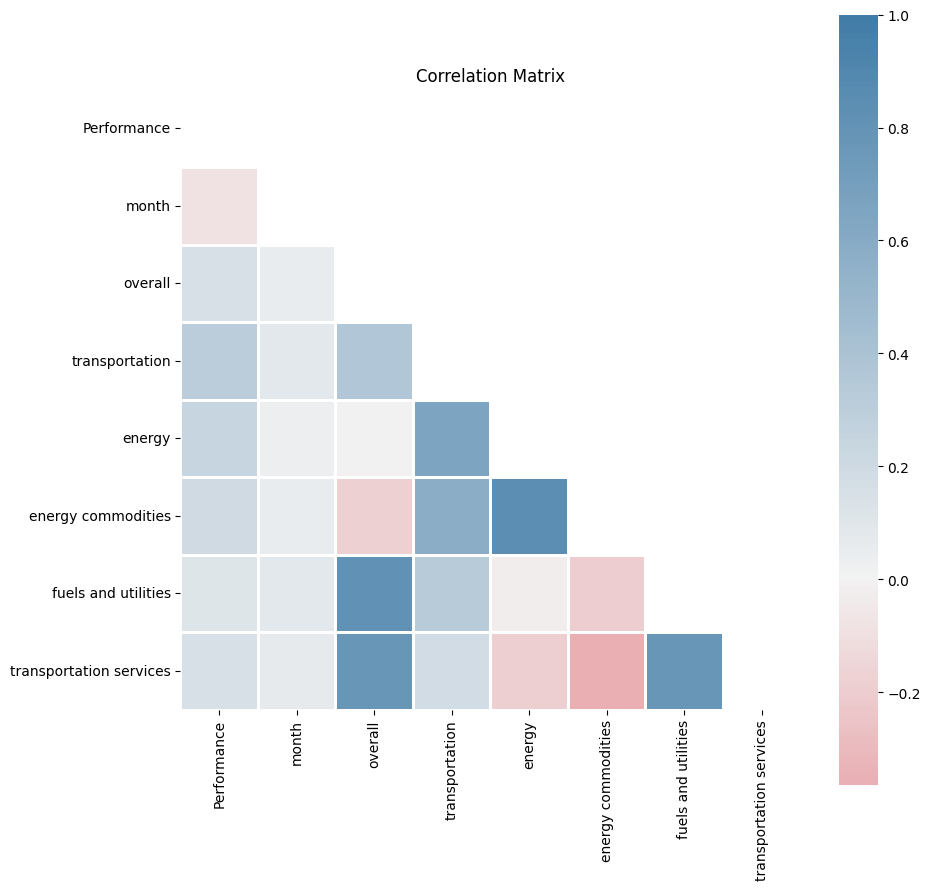

In [42]:
dd.correlation_matrix(samples)

In [43]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [44]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({1: 6535, 0: 3465})
Counter({1: 6535, 0: 6535})


### Interaction Terms

In [45]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  242.64818338,   201.0580264 ,   199.10358734, ...,
        46032.42189724, 65495.10916297, 68211.1324494 ],
       [  279.45664172,   249.07528283,   241.3611974 , ...,
        60742.6496943 , 74886.06626392, 82958.11141537],
       [  252.81528003,   215.66132027,   239.77509694, ...,
        75999.65950357, 96768.57419227, 83307.91646511],
       ...,
       [  234.16753383,   195.40202952,   192.84736398, ...,
        42543.11969855, 61028.26340186, 69123.29318178],
       [  232.72199518,   216.79164758,   243.11133793, ...,
        69493.45120333, 89757.41044809, 64270.30556601],
       [  227.9246837 ,   211.23459554,   246.49079693, ...,
        68660.6253099 , 80676.84512686, 54525.95100415]])

In [46]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(13070, 22)

In [47]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(143, 22)

In [48]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [49]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.724407,0.77311,0.641003,0.699784,0.71787,0.750181,0.643344,0.692667,0.573427,0.6625,0.609195,0.634731
1,DecisionTreeClassifier,0.700536,0.714799,0.672223,0.692179,0.684517,0.683648,0.673065,0.678315,0.545455,0.634146,0.597701,0.615385
2,RandomForestClassifier,0.792808,0.83167,0.741537,0.782473,0.77601,0.796907,0.733746,0.764023,0.629371,0.67,0.770115,0.716578
3,AdaBoostClassifier,0.695792,0.703281,0.678346,0.690415,0.698898,0.699305,0.685449,0.692308,0.643357,0.695652,0.735632,0.715084
4,GradientBoostingClassifier,0.710712,0.719878,0.690125,0.704638,0.709914,0.723376,0.668731,0.694981,0.643357,0.704545,0.712644,0.708571
5,ExtraTreesClassifier,0.81645,0.855613,0.770767,0.808936,0.78825,0.809524,0.747368,0.777205,0.643357,0.676471,0.793103,0.730159
6,BaggingClassifier,0.746366,0.80178,0.659061,0.722537,0.730416,0.766715,0.653251,0.70545,0.58042,0.666667,0.62069,0.642857
7,SVC,0.673527,0.680129,0.655852,0.667691,0.682069,0.683439,0.664396,0.673783,0.678322,0.72043,0.770115,0.744444
8,GaussianNB,0.625478,0.628821,0.613465,0.620945,0.628519,0.628279,0.60805,0.617999,0.622378,0.698795,0.666667,0.682353


### Voting Classifier

In [50]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.779376,0.799197,0.739319,0.768093


## Using data after 2000

In [51]:
data = pd.read_csv('../data/S&P 500 Materials 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2000]
data

,year,month,date,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),S&P 500 Materials (Sector) Outperform/Underperform,overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
80,2000,1,2000-01-13,1449.68,161.000000,-4.867901,19.197447,OUTPERFORM,170.000,150.000,118.800,122.400,134.500,193.600,3
81,2000,2,2000-02-10,1416.83,134.789993,-0.911278,-1.541272,UNDERPERFORM,171.000,153.600,124.300,133.400,133.600,194.400,3
82,2000,3,2000-03-09,1401.69,122.080002,-0.373858,-12.430960,UNDERPERFORM,170.900,152.100,120.900,126.100,133.700,194.700,3
83,2000,4,2000-04-13,1440.51,144.729996,-1.016965,21.713894,OUTPERFORM,171.200,152.000,120.000,124.100,133.800,195.500,3
84,2000,5,2000-05-11,1407.81,138.949997,-3.857159,16.285881,OUTPERFORM,172.200,155.000,126.800,134.900,136.600,196.000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,511.019989,-2.530346,0.450136,OUTPERFORM,273.092,236.783,242.958,276.734,262.483,326.470,3
339,2021,8,2021-08-12,4460.83,541.940002,-1.849766,1.732646,OUTPERFORM,274.214,237.107,245.847,280.047,265.333,323.329,3
340,2021,9,2021-09-09,4493.28,525.940002,-4.490556,-5.224081,UNDERPERFORM,276.590,241.826,255.010,293.342,270.870,323.995,3
341,2021,10,2021-10-14,4438.26,526.789978,-7.366228,-6.514645,OUTPERFORM,278.524,246.749,261.257,305.653,271.467,326.256,3


In [52]:
original = data[['S&P 500 Materials (Sector) Outperform/Underperform','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
data.drop(columns=['date','S&P 500 Materials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Materials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
0,4,1219.657923,122.496458,5.876530,-5.487248,185.346315,158.322194,129.612289,133.947914,147.423165,207.221568,3
1,10,1268.780254,218.448077,-7.850516,-9.009205,229.402766,220.792926,247.959889,308.660951,212.205223,258.522828,3
2,11,2540.273475,185.590683,10.839566,5.553499,198.712820,194.871481,200.600526,239.670146,222.115906,300.175538,3
3,3,1238.377408,190.103649,-0.451211,-2.539907,184.491552,158.831340,223.011879,149.417371,227.088198,220.838628,3
4,8,3072.842547,647.708235,9.932223,21.543555,252.805182,213.618958,219.402809,238.614092,248.877055,328.609014,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,12,1427.057337,337.324879,2.206034,-0.689510,227.700049,209.963194,212.761184,247.205976,212.655968,285.474155,3
9996,1,1227.410740,155.575272,-0.109922,-1.736489,177.633172,167.036876,158.899266,291.598660,147.684906,231.029075,3
9997,1,3199.627556,310.871388,-1.409595,-5.218569,251.284182,220.074645,250.271129,300.197939,225.547201,321.450192,3
9998,8,1523.674015,333.114849,0.634834,-3.130950,255.725425,227.861953,255.983438,298.461032,233.202608,300.725390,3


In [53]:
samples['Performance'] = np.where(samples['S&P 500 Materials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.6769,0.645726,0.775707,0.704028,0.663256,0.630256,0.755378,0.687168,0.574144,0.614173,0.553191,0.58209
1,DecisionTreeClassifier,0.653424,0.64137,0.690841,0.664195,0.64189,0.622822,0.681008,0.650617,0.532319,0.575,0.489362,0.528736
2,RandomForestClassifier,0.757788,0.737313,0.793738,0.761705,0.723443,0.702055,0.755993,0.728026,0.547529,0.605769,0.446809,0.514286
3,AdaBoostClassifier,0.626035,0.618742,0.65551,0.636525,0.623533,0.603638,0.673018,0.636443,0.570342,0.618644,0.51773,0.563707
4,GradientBoostingClassifier,0.63988,0.624542,0.6999,0.65993,0.633163,0.606583,0.713583,0.655747,0.574144,0.607407,0.58156,0.594203
5,ExtraTreesClassifier,0.783371,0.764836,0.811641,0.784467,0.757448,0.738802,0.780578,0.759115,0.51711,0.574468,0.382979,0.459574
6,BaggingClassifier,0.705643,0.706155,0.699408,0.701084,0.697562,0.699104,0.671174,0.684854,0.536122,0.594059,0.425532,0.495868
7,SVC,0.620843,0.603947,0.698686,0.64765,0.616912,0.590398,0.71051,0.644909,0.581749,0.611511,0.602837,0.607143
8,GaussianNB,0.555455,0.547915,0.63355,0.587603,0.556726,0.540021,0.638599,0.585187,0.596958,0.62963,0.602837,0.615942


## Using all data

In [54]:
data = pd.read_csv('../data/S&P 500 Materials 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),S&P 500 Materials (Sector) Outperform/Underperform,overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
0,1993,5,1993-05-13,439.23,90.330002,-2.195551,-0.407933,OUTPERFORM,144.300,129.900,103.900,96.400,121.400,162.600,3
1,1993,6,1993-06-10,445.38,89.989998,-2.363206,-1.789806,OUTPERFORM,144.500,130.100,103.400,95.300,121.700,163.200,3
2,1993,7,1993-07-08,448.64,89.849998,-2.220866,-0.011132,OUTPERFORM,144.800,130.500,103.400,95.000,122.100,163.900,3
3,1993,8,1993-08-12,448.96,89.269997,-3.088911,-0.932198,OUTPERFORM,145.000,130.400,103.000,93.900,122.500,164.000,3
4,1993,9,1993-09-09,457.50,89.269997,-1.320047,-4.503643,UNDERPERFORM,145.600,132.000,105.300,98.300,122.600,164.400,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,511.019989,-2.530346,0.450136,OUTPERFORM,273.092,236.783,242.958,276.734,262.483,326.470,3
339,2021,8,2021-08-12,4460.83,541.940002,-1.849766,1.732646,OUTPERFORM,274.214,237.107,245.847,280.047,265.333,323.329,3
340,2021,9,2021-09-09,4493.28,525.940002,-4.490556,-5.224081,UNDERPERFORM,276.590,241.826,255.010,293.342,270.870,323.995,3
341,2021,10,2021-10-14,4438.26,526.789978,-7.366228,-6.514645,OUTPERFORM,278.524,246.749,261.257,305.653,271.467,326.256,3


In [55]:
original = data[['S&P 500 Materials (Sector) Outperform/Underperform','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
data.drop(columns=['date','S&P 500 Materials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Materials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
0,12,1932.713752,158.601042,-2.879250,-8.798014,219.744070,208.010984,195.669713,205.053973,220.513659,296.557617,3
1,5,1308.027555,303.821448,1.331222,-1.750391,230.118401,218.623486,229.283893,312.375057,233.728896,318.566474,3
2,6,560.291712,109.433391,7.685468,2.446976,140.956937,138.919431,104.666063,96.754738,121.597105,164.743971,3
3,11,2518.807873,207.996906,-8.422750,-5.472612,221.781894,219.372055,278.053175,335.447369,220.878167,253.908751,3
4,5,4503.756342,253.108437,-4.571920,-1.395233,228.711208,220.667324,254.506177,323.164229,227.666774,313.603410,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5,886.077737,321.611501,5.867690,5.880802,199.367332,185.686600,171.252193,208.814584,206.929593,298.278860,3
9996,3,3043.175131,354.745644,-11.006427,-7.559295,245.736586,236.799565,254.368909,233.372035,263.655611,326.263004,3
9997,3,4694.742988,337.978608,-0.766607,-0.797565,231.183024,242.537029,245.811462,230.870499,270.111219,312.367660,3
9998,4,917.801836,136.809479,-1.959846,13.146827,169.833230,159.728597,136.909579,122.629221,147.798252,195.940754,3


In [56]:
samples['Performance'] = np.where(samples['S&P 500 Materials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.595831,0.610282,0.543718,0.574099,0.591059,0.586864,0.557718,0.57192,0.559767,0.616216,0.587629,0.601583
1,DecisionTreeClassifier,0.603232,0.61518,0.571992,0.591428,0.576266,0.569743,0.551007,0.560218,0.562682,0.623596,0.572165,0.596774
2,RandomForestClassifier,0.691171,0.720272,0.655164,0.682136,0.658777,0.657382,0.633557,0.645249,0.577259,0.61086,0.695876,0.650602
3,AdaBoostClassifier,0.574458,0.581889,0.531538,0.554744,0.577581,0.583266,0.481879,0.527747,0.577259,0.713043,0.42268,0.530744
4,GradientBoostingClassifier,0.589004,0.590885,0.580038,0.585171,0.585141,0.573548,0.596644,0.584868,0.586006,0.656627,0.561856,0.605556
5,ExtraTreesClassifier,0.708512,0.741317,0.684252,0.704557,0.677515,0.672542,0.665772,0.66914,0.568513,0.603604,0.690722,0.644231
6,BaggingClassifier,0.633803,0.6744,0.535336,0.594875,0.610125,0.626456,0.505369,0.559435,0.559767,0.611399,0.608247,0.609819
7,SVC,0.570184,0.569407,0.57708,0.573016,0.570677,0.558008,0.59396,0.575423,0.580175,0.660256,0.530928,0.588571
8,GaussianNB,0.538217,0.558469,0.368833,0.444149,0.543064,0.551653,0.358389,0.4345,0.533528,0.677083,0.335052,0.448276
